<a href="https://colab.research.google.com/github/elibtronic/2025_state_of_scholarly_communication/blob/main/2025_SofSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 2025 State of Scholarly Communication

Uses OpenAlex data based on pub year and ROR on record
Augmented with Policy Finder Data



In [119]:
import requests
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import seaborn as sns
from datetime import datetime
from google.colab import files

#Set graph colors
colors = sns.color_palette('inferno_r')
color = sns.color_palette('inferno_r')[0]


# @markdown ## OpenAlex Settings

mailto = "tribaric@brocku.ca"  # @param {type:"string"}

ror_id     = "056am2717"  # @param {type:"string"}
from_publication_date = "2025-01-01"  # @param {type:"date"}
to_publication_date = "2025-09-01"  # @param {type:"date"}

# @markdown ## Policy Finder API Settings

pf_key = "" # @param {"type":"string"}

filter = f"authorships.institutions.ror:{ror_id},from_publication_date:{from_publication_date},to_publication_date:{to_publication_date},type:article,primary_location.source.type:journal"
api_url = f"https://api.openalex.org/works?filter={filter}&per-page=200&mailto={mailto}"

cursor = "*"  # Cursor for the first request
works = []  # List to accumulate all results

while cursor:
    # Construct the request URL with the current cursor
    request_url = api_url + f"&cursor={cursor}"

    # Get results from the API
    page = requests.get(request_url).json()
    results = page.get('results')
    meta = page.get('meta')

    # Accumulate results
    works += results

    # Get the next cursor from the current results
    cursor = meta.get('next_cursor')

    # Print progress
    total = int(meta.get("count"))
    #print(f"\r{len(works)}/{total}: {request_url}", end="")

# Do something with all results
print(f"\nTotal works: {len(works)}")


Total works: 402


## Open Alex Data Fetch

Extracts
- ORCID of first Brock Author
- Publication Date
- DOI of piece
- Item already Open Access?
- ISSN of piece
- source of item
- publisher of item

Still to do


In [139]:
orcid_list = []
pub_date_list = []
doi_list = []
issn_list = []
already_oa_list = []
oa_status_list = []
source_list = []
publisher_list = []


for work in works:
  doi_list.append(work['doi'])

  orcid = ""
  for author in work['authorships']:
    for intst in author['institutions']:
      if (intst['ror'] == "https://ror.org/"+ror_id) and orcid == "":
        orcid = author['author']['orcid']
  orcid_list.append(orcid)

  try:
    issn = work['primary_location']['source']['issn'][0]
  except:
    issn = ""
  issn_list.append(issn)

  try:
    pub_date = work['publication_date']
  except:
    pub_date = ""
  pub_date_list.append(pub_date)

  if work['open_access']['is_oa'] == True:
    already_oa = "yes"
  else:
    already_oa = "no"
  already_oa_list.append(already_oa)

  try:
    oa_status = work['open_access']['oa_status']
  except:
    oa_status = ""
  oa_status_list.append(oa_status)

  try:
    source = work['primary_location']['source']['display_name']
  except:
    source = ""
  source_list.append(source)

  try:
    publisher = work['primary_location']['source']['host_organization_name']
  except:
    publisher = ""
  publisher_list.append(publisher)


  df = pd.DataFrame(list(zip(orcid_list, pub_date_list,doi_list,already_oa_list,oa_status_list,issn_list,source_list,publisher_list)), columns =['ORCID','pub_date','DOI','already_oa','oa_status','issn','source','publisher'])

In [ ]:
df.sample(10)

In [133]:
import random
random_work = random.choice(works)

In [ ]:
pprint(random_work)

In [ ]:
random_work['open_access']

## Policy Finder

Grabs associated Policy Finder policy for ISSN of DOI

In [ ]:
#As there is no Python wrapper for this API, I'll make a function
#that will use requests to grab the JSON
def pf_fetch(pf_key,issn):
  '''Returns JSON from Policy Finder given an ISSN and API Key'''
  paip_options = {
      "item-type" : "publication",
      "api-key" : pf_key,
      "format" : "Json",
  }

  paip_options['identifier'] = issn

  requests.packages.urllib3.disable_warnings()
  api_blob = requests.get("https://v2.sherpa.ac.uk/cgi/retrieve_by_id",params=paip_options,verify=False).json()

  if api_blob['items'] == []:
    return None
  else:
    return api_blob['items'][0]

In [ ]:
list_uri = []
list_submitted_oa_policy = []
list_accepted_oa_policy = []
list_published_oa_policy = []
prog = 0

print("Retrieving PolicyFinder data for ", len(df), " DOIs")

for key, value in df.iterrows():

  #some low-fi progress feedback
  prog += 1
  if prog % 50 == 0:
    print(str(prog)+"..", end = "")
  if prog % 500 == 0:
    print("\n")

  if value['issn'] == "":
    #print("no issn")
    list_uri.append("None")
    list_submitted_oa_policy.append("None")
    list_accepted_oa_policy.append("None")
    list_published_oa_policy.append("None")
  else:
    #print(value['issn'])
    par = pf_fetch(pf_key,value['issn'])

    #No policy found in otherwords
    if par == None:
      list_uri.append("None")
      list_submitted_oa_policy.append("None")
      list_accepted_oa_policy.append("None")
      list_published_oa_policy.append("None")
    else:
      policy_uri = par['system_metadata']['uri']
      accepted_oa_policy = ""
      published_oa_policy = ""
      submitted_oa_policy = ""
      for pub_policy in par['publisher_policy']:
        for per_oa in pub_policy['permitted_oa']:
          try:
            #Only keep ones that have IR as option, for first pass
            if 'institutional_repository' in per_oa['location']['location']:
              #accepted policy first
              if per_oa['article_version'][0] == 'accepted':
                try:
                  conditions_text = " ".join(per_oa['conditions'])
                except:
                  conditions_text = "no conditions"
                if per_oa['additional_oa_fee'] == "no":
                  fee_text = "fee_no"
                else:
                  fee_text = "fee_yes"
                per_id = str(per_oa['id'])
                accepted_oa_policy += per_id+":"+fee_text+":"+conditions_text+";"

              #published
              elif per_oa['article_version'][0] == 'published':
                try:
                  conditions_text = " ".join(per_oa['conditions'])
                except:
                  conditions_text = "no conditions"
                if per_oa['additional_oa_fee'] == "no":
                  fee_text = "fee_no"
                else:
                  fee_text = "fee_yes"
                per_id = str(per_oa['id']).strip()
                published_oa_policy += per_id+":"+fee_text+":"+conditions_text+";"

              #submitted
              elif per_oa['article_version'][0] == 'submitted':
                try:
                  conditions_text = " ".join(per_oa['conditions'])
                except:
                  conditions_text = "no conditions"
                if per_oa['additional_oa_fee'] == "no":
                  fee_text = "fee_no"
                else:
                  fee_text = "fee_yes"
                per_id = str(per_oa['id']).strip()
                submitted_oa_policy += per_id+":"+fee_text+":"+conditions_text+";"
          except: #on occasion it error out totally
            #print("error")
            policy_uri = "error"
            accepted_oa_policy = "error"
            published_oa_policy = "error"
            submitted_oa_policy = "error"

        if submitted_oa_policy == "":
          submitted_oa_policy = "None"
        if accepted_oa_policy == "":
          accepted_oa_policy = "None"
        if published_oa_policy == "":
          published_oa_policy = "None"

      #print("\n")
      #print(policy_uri)
      list_uri.append(policy_uri)
      #print(submitted_oa_policy)
      list_submitted_oa_policy.append(submitted_oa_policy)
      #print(accepted_oa_policy)
      list_accepted_oa_policy.append(accepted_oa_policy)
      #print(published_oa_policy)
      list_published_oa_policy.append(published_oa_policy)

# add these new columns to the df
df['policy_uri'] = list_uri
df['submitted_oa_policy'] = list_submitted_oa_policy
df['accepted_oa_policy'] = list_accepted_oa_policy
df['published_oa_policy'] = list_published_oa_policy

print("\nDone retrieving PolicyFinder data.")

Retrieving PolicyFinder data for  402  DOIs
50..100..150..200..250..300..350..400..
Done retrieving PolicyFinder data.


In [ ]:
#Testing data parts
pprint(work['primary_location']['source']['display_name'])
pprint(work['primary_location']['source']['host_organization_name'])

'Palliative Care and Social Practice'
'SAGE Publishing'


# Analysis

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

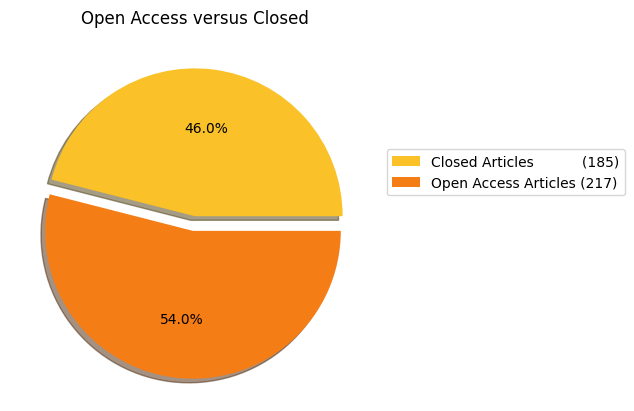

In [ ]:
#Total Versus OA as pie

not_oa = df['already_oa'].value_counts()['no']
oa = df['already_oa'].value_counts()['yes']
explode = (0, 0.1)
legend = ["Closed Articles           ("+str(not_oa)+")","Open Access Articles ("+str(oa)+")"]

plt.pie([not_oa,oa],autopct="%1.1f%%",explode=explode,shadow=True,startangle=0,colors=colors)
plt.legend(legend,bbox_to_anchor=(1.0,0.7))
plt.title("Open Access versus Closed")

figname = "Open_Access_versus_Closed.png"
plt.savefig(figname)
files.download(figname)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

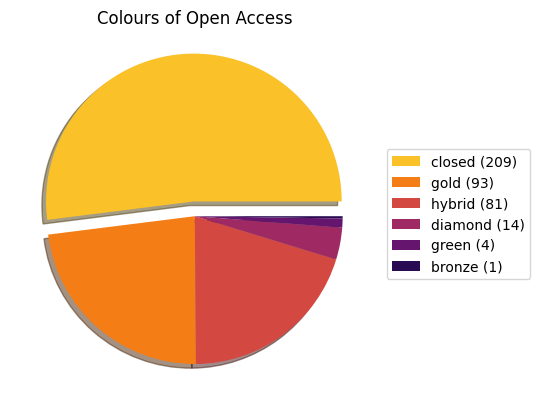

In [189]:
#colors of OA as pie

oa_colors = df['oa_status'].value_counts().values
legend = df['oa_status'].value_counts().index
legend = ['%s (%1d)' % (l, s) for l, s in zip(df['oa_status'].value_counts().index, df['oa_status'].value_counts().values)]
explode = (0.1, 0.0, 0, 0, 0, 0)

plt.pie(oa_colors,shadow=True,explode=explode, startangle=0,colors=colors)
plt.legend(legend,bbox_to_anchor=(1.0,0.7))
plt.title("Colours of Open Access")

figname = "Colours_of_Open_Access.png"
plt.savefig(figname)
files.download(figname)

plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

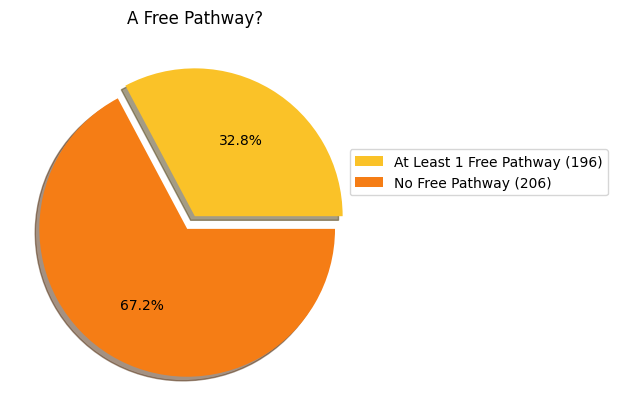

In [ ]:
#Articles with at least 1 free pathway

least_one_free_pathway = len(df[df['submitted_oa_policy'].str.contains('fee_no', case=False) | df['accepted_oa_policy'].str.contains('fee_no', case=False) | df['published_oa_policy'].str.contains('fee_no', case=False)])
total = len(df)
legend = ["At Least 1 Free Pathway ("+str(least_one_free_pathway)+")","No Free Pathway ("+str(total-least_one_free_pathway)+")"]

plt.pie([least_one_free_pathway,total],autopct="%1.1f%%",explode=explode,shadow=True,startangle=0,colors=colors)
plt.legend(legend,bbox_to_anchor=(0.9,0.7))
plt.title("A Free Pathway?")

figname = "One_Free_Pathway.png"
plt.savefig(figname)
files.download(figname)
plt.show()

In [ ]:
#top 10 sources
#df.value_counts('source')[0:10]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

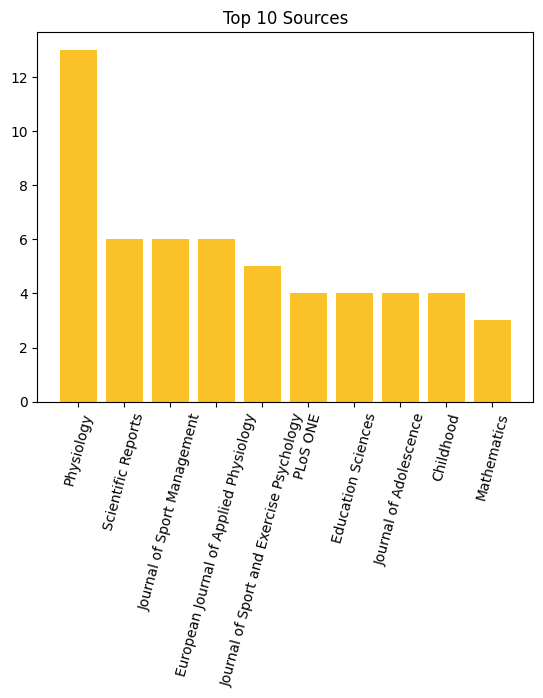

In [ ]:
plt.bar(df.value_counts('source')[0:10].index,df.value_counts('source')[0:10],color=color)
plt.xticks(rotation=75)
plt.title("Top 10 Sources")

figname = "Top_10_Sources.png"
plt.savefig(figname)
files.download(figname)
plt.show()

In [ ]:
#top 10 publishers
#df.value_counts('publisher')[0:10]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

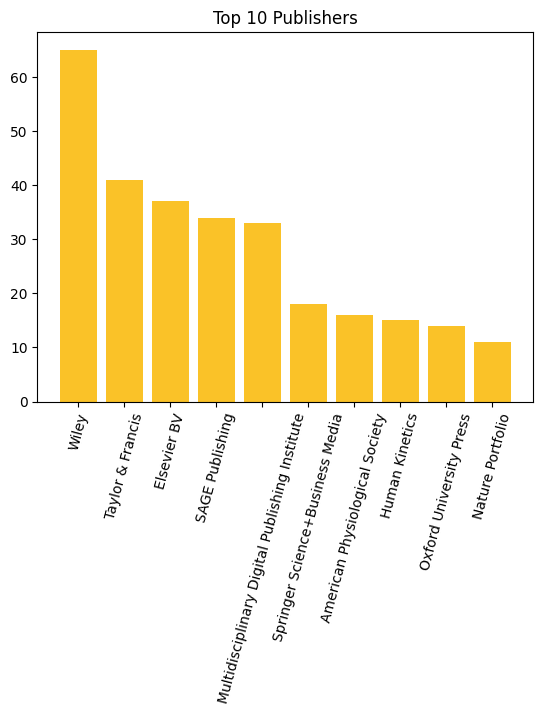

In [ ]:
#top 10 publishers
plt.bar(df.value_counts('publisher')[0:10].index,df.value_counts('publisher')[0:10],color=color)
plt.xticks(rotation=75)
plt.title("Top 10 Publishers")

figname = "Top_10_Publishers.png"
plt.savefig(figname)
files.download(figname)
plt.show()

In [ ]:
#top 10 ORCIDS
#df.value_counts('ORCID')[0:10]

#Samples from Data set

In [ ]:
#Just a sample of what we have
df.sample(10)

,ORCID,pub_date,DOI,already_oa,issn,source,publisher,policy_uri,submitted_oa_policy,accepted_oa_policy,published_oa_policy
98,https://orcid.org/0000-0003-1633-9757,2025-01-09,https://doi.org/10.1016/j.preghy.2025.101187,no,2210-7789,Pregnancy Hypertension,Elsevier BV,https://v2.sherpa.ac.uk/id/publication/18856,None,None,10952:fee_yes:Published source must be acknowl...
128,https://orcid.org/0000-0003-2161-5613,2025-02-11,https://doi.org/10.1002/aur.70001,yes,1939-3806,Autism Research,Wiley,https://v2.sherpa.ac.uk/id/publication/230,None,None,None
282,https://orcid.org/0000-0002-3829-7466,2025-06-19,https://doi.org/10.1007/s00421-025-05851-w,no,1439-6319,European Journal of Applied Physiology,Springer Science+Business Media,https://v2.sherpa.ac.uk/id/publication/28234,None,None,None
250,https://orcid.org/0000-0002-0448-7106,2025-05-27,https://doi.org/10.1177/03128962251334223,no,0312-8962,Australian Journal of Management,SAGE Publishing,https://v2.sherpa.ac.uk/id/publication/6429,None,None,None
16,https://orcid.org/0000-0002-5516-4542,2025-01-24,https://doi.org/10.3390/molecules30030535,yes,1420-3049,Molecules,Multidisciplinary Digital Publishing Institute,https://v2.sherpa.ac.uk/id/publication/19458,None,None,None
249,https://orcid.org/0000-0001-5678-7234,2025-05-01,https://doi.org/10.1136/bmjopen-2023-082610,yes,2044-6055,BMJ Open,BMJ,https://v2.sherpa.ac.uk/id/publication/17945,None,None,None
274,https://orcid.org/0000-0001-8925-3108,2025-06-11,https://doi.org/10.3390/educsci15060730,yes,2227-7102,Education Sciences,Multidisciplinary Digital Publishing Institute,https://v2.sherpa.ac.uk/id/publication/24796,None,None,None
178,https://orcid.org/0000-0003-1297-1667,2025-03-30,https://doi.org/10.1016/j.jecp.2025.106243,yes,0022-0965,Journal of Experimental Child Psychology,Elsevier BV,https://v2.sherpa.ac.uk/id/publication/11373,None,11157:fee_no:Must link to publisher version wi...,11159:fee_yes:Published source must be acknowl...
38,https://orcid.org/0000-0002-3622-1548,2025-01-15,https://doi.org/10.3390/rs17020289,yes,2072-4292,Remote Sensing,Multidisciplinary Digital Publishing Institute,https://v2.sherpa.ac.uk/id/publication/13675,None,None,None
168,None,2025-03-01,https://doi.org/10.1029/2024ef005518,yes,2328-4277,Earth s Future,American Geophysical Union,https://v2.sherpa.ac.uk/id/publication/25916,None,None,None


# Write out to File

In [ ]:
#DOI data as CSV
csv_file_name = "Brock_OpenAlex_Harvest_Start_Date_"+from_publication_date+"_to_"+to_publication_date+".csv"
print("Saving to file: "+csv_file_name)
df.to_csv(csv_file_name,index=False)
files.download(csv_file_name)

Saving to file: Brock_OpenAlex_Harvest_Start_Date_2025-01-01_to_2025-09-01.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>